Analysing how a synthetic long position would work:

Assuming that the senators stock pick appreciates within 90 days:
- Sell cash-secured OTM put, collect premium
- use premium to purchase OTM call
- exit position just before expiration

P/L profile is similar to owning 100 shares of underlying stock

Let:
S = underlying stock price
K = common strike price of long call and short put
C = Premium paid for the long call
P = Premium received for short put
NND = net debit or net credit to enter the strategy
    where NND = C - P

Scenario:
S > K ,  P/L = S - K - (C - P)
S = K ,  P/L = -(C - P) or -NND
S < K ,  P/L = S-K-(C-P)

Disclaimer:
I'm projecting a 10% increase in the underlying stock price just to simplify this exercise, this isn't based on any analysis. I've pulled the number out of thin air

In [1]:
import os
import pandas as pd, numpy as np
import boto3

In [2]:
dynamodb = boto3.resource(
            'dynamodb',
            region_name='eu-north-1',
            aws_access_key_id=os.getenv('AWS_ACCESS_KEY'),
            aws_secret_access_key=os.getenv('AWS_SECRET_KEY')
)

table = dynamodb.Table(os.getenv('DYNAMO_TABLE_NAME'))
items = []
resp = table.scan()
items.extend(resp.get('Items', []))
while resp.get('LastEvaluatedKey') is not None:
    resp = table.scan(ExclusiveStartKey=resp['LastEvaluatedKey'])
    items.extend(resp.get('Items', []))
df = pd.DataFrame(items)
df.head()

,Tx_Type,Comment,Date,Asset_Type,Filer,Owner,Ticker,Amount,id,Asset_Name
0,Sale (Partial),None,2025-09-04,Stock,"Whitehouse, Sheldon",Self,AAPL,"$15,001 - $50,000",3a7413ed5ad650c3e08beedc139b362c,Apple Inc
1,Sale (Full),None,2023-09-20,Stock,"Whitehouse, Sheldon",Spouse,WBD,"$1,001 - $15,000",f32d3026cd93624cf66552159148bd02,"Warner Bros. Discovery, Inc. - Series A Common..."
2,Sale (Full),None,2014-06-19,,"Collins, Susan M.",Spouse,PG,"$1,001 - $15,000",0ba73920a5ed82d8e83d9f1230fb6668,The Procter & Gamble Company (NYSE)
3,Purchase,None,2016-03-31,Stock,"Cassidy, Bill",Spouse,PG,"$1,001 - $15,000",ebc244ac5e18600af7b7517299893b8d,The Procter & Gamble Company
4,Sale (Partial),None,2019-09-25,Stock,"Moran, Jerry",Spouse,XOM,"$1,001 - $15,000",609a7b92833dc517cfd19953347d4a9f,Exxon Mobil Corporation


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
recent_buys = df[(df['Date'] >= '2025-09-01') & (df['Tx_Type'] == 'Purchase') & (df['Ticker'])]
recent_buys = recent_buys.sort_values(by='Date', ascending=False)
recent_buys.head(5)

,Tx_Type,Comment,Date,Asset_Type,Filer,Owner,Ticker,Amount,id,Asset_Name
1242,Purchase,None,2025-09-24,Stock,"Mullin, Markwayne",Joint,ISRG,"$50,001 - $100,000",6f923961513c562b495f1069352cdfa5,"Intuitive Surgical, Inc. - Common Stock"
1369,Purchase,None,2025-09-24,Stock,"Mullin, Markwayne",Joint,UNH,"$15,001 - $50,000",443908ce011136867f61de5665885e88,Unitedhealth Group Inc
1969,Purchase,None,2025-09-24,Stock,"Mullin, Markwayne",Joint,INTU,"$15,001 - $50,000",47442d16a1d0aa8dcc1e2b0584b34e59,Intuit Inc. - Common Stock
4763,Purchase,None,2025-09-24,Stock,"Mullin, Markwayne",Joint,NOW,"$1,001 - $15,000",79a9c5d7e00284096bb9c6f3c3ec7bd2,"ServiceNow, Inc. Common Stock"
5925,Purchase,None,2025-09-17,Stock,"Boozman, John",Joint,GOOGL,"$15,001 - $50,000",cdbf6c0b009fb9e4a2ffb93e9a54ff0f,Alphabet Cl A


In [4]:
import yfinance as yf
from datetime import datetime, timedelta

In [5]:
def get_otm_options(ticker_symbol: str, tx_date: pd.Timestamp):
    target_date = tx_date + timedelta(days=90)
    ticker = yf.Ticker(ticker_symbol)
    expirations = [datetime.fromisoformat(d) for d in ticker.options]
    nearest_exp = min(expirations, key=lambda d: abs((d - target_date).days))
    return ticker.option_chain(nearest_exp.strftime('%Y-%m-%d'))

In [6]:
otm_calls = get_otm_options('ISRG', pd.Timestamp('2025-09-24')).calls
otm_calls = otm_calls[otm_calls['inTheMoney'] == False]

In [7]:
otm_calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
41,ISRG251219C00530000,2025-10-22 19:57:36+00:00,530.0,25.0,0.0,0.0,0.0,0.0,48.0,0,0.003916,False,REGULAR,USD
42,ISRG251219C00535000,2025-10-22 19:43:42+00:00,535.0,22.4,0.0,0.0,0.0,0.0,38.0,0,0.007822,False,REGULAR,USD
43,ISRG251219C00540000,2025-10-22 19:07:46+00:00,540.0,19.0,0.0,0.0,0.0,0.0,172.0,0,0.015635,False,REGULAR,USD
44,ISRG251219C00545000,2025-10-22 15:33:23+00:00,545.0,18.1,0.0,0.0,0.0,0.0,29.0,0,0.015635,False,REGULAR,USD
45,ISRG251219C00550000,2025-10-22 19:54:52+00:00,550.0,16.0,0.0,0.0,0.0,0.0,152.0,0,0.031260,False,REGULAR,USD


In [8]:
# current stock price
ticker = yf.Ticker('ISRG')
current_price = ticker.history(period='1d')['Close'].iloc[0]
current_price

np.float64(527.030029296875)

In [9]:
current_price * 1.1

np.float64(579.7330322265625)

In [10]:
# get call options with strike price +10% above current price
otm_calls = otm_calls[otm_calls['strike'] >= current_price * 1.1]
otm_calls = otm_calls.sort_values(by='strike', ascending=True)
otm_calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
51,ISRG251219C00580000,2025-10-22 17:19:13+00:00,580.0,7.2,0.0,0.0,0.0,0.0,14.0,0,0.062509,False,REGULAR,USD
52,ISRG251219C00585000,2025-10-22 18:45:25+00:00,585.0,7.4,0.0,0.0,0.0,0.0,4.0,0,0.062509,False,REGULAR,USD
53,ISRG251219C00590000,2025-10-22 17:49:15+00:00,590.0,5.4,0.0,0.0,0.0,0.0,35.0,0,0.062509,False,REGULAR,USD
54,ISRG251219C00595000,2025-10-22 18:42:05+00:00,595.0,5.5,0.0,0.0,0.0,0.0,11.0,0,0.062509,False,REGULAR,USD
55,ISRG251219C00600000,2025-10-22 19:56:47+00:00,600.0,5.0,0.0,0.0,0.0,0.0,132.0,0,0.062509,False,REGULAR,USD


In [11]:
# get put options with strike price +10% above current price
otm_puts = get_otm_options('ISRG', pd.Timestamp('2025-09-24')).puts
otm_puts = otm_puts[otm_puts['strike'] >= current_price * 1.1]
otm_puts = otm_puts.sort_values(by='strike', ascending=True)
otm_puts.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
51,ISRG251219P00600000,2025-10-03 16:45:17+00:00,600.0,145.61,0.0,0.0,0.0,0.0,1.0,0,0.00001,True,REGULAR,USD


In [12]:
otm_calls_510 = otm_calls[otm_calls['strike'] == 510]
otm_puts_510 = otm_puts[otm_puts['strike'] == 510]

In [13]:
otm_calls_510

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency


In [14]:
otm_puts_510

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency


So here's the parameters (assuming we get the lastPrice):

S = 462 (today)

K = 510
C = 13.6
P = 75.63
NND = 75.63 - 13.6 = 62.03

scenarios:
- S > K , S = 515:
P/L = (515 - 510) + 62.03 = $67.03

- S < L, S = 500
P/L = (-13.6) + (75.63) = 62.03

- S == K, S = 510
P/L = 62.03

- S < L, S = 400
P/L = (400 - 510) + 62.03 = -47.97

In [15]:
# Let's visualise the payoff diagram
import matplotlib.pyplot as plt

In [16]:
def get_profit_loss(strike_price, premium_call, premium_put, stock_price):
    S = stock_price
    K = strike_price

    call_payoff = max(0, S - K) - premium_call
    put_payoff = premium_put - max(0, K - S)
    total_payoff = call_payoff + put_payoff
    return total_payoff

In [17]:
pl = []
stock_prices = np.arange(400, 700, 1)
strike_price = 510
premium_call = otm_calls_510['lastPrice'].values[0]
premium_put = otm_puts_510['lastPrice'].values[0]

for price in stock_prices:
    profit_loss = get_profit_loss(strike_price, premium_call, premium_put, price)
    pl.append(profit_loss)

IndexError: index 0 is out of bounds for axis 0 with size 0

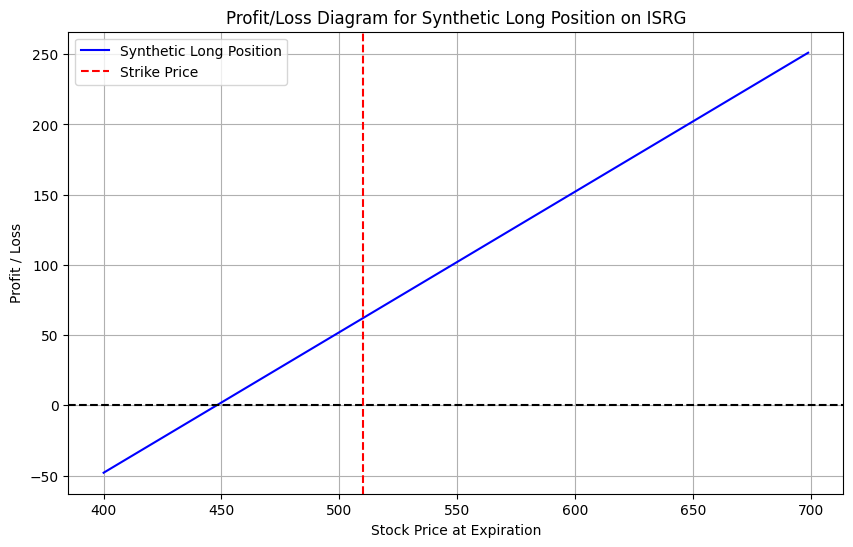

In [ ]:
# let's plot the profit/loss diagram
plt.figure(figsize=(10,6))
plt.plot(stock_prices, pl, label='Synthetic Long Position', color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(strike_price, color='red', linestyle='--', label='Strike Price')
plt.title('Profit/Loss Diagram for Synthetic Long Position on ISRG')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Profit / Loss')
plt.legend()
plt.grid()
plt.show()

# Conclusion

It's a really difficult trade to analyse. We're assuming that each senator has inside information that isn't priced into the market, and historical returns support this theory. But, at the end of the day it's a gamble

The short put is risky as well, because if the stock tanks you're obligated to buy it at the much higher OTM price.

You'd have to be very confident in the senators investment decision.

I believe you could refine this further by identifying which senators tend to make better investments, how long they typically hold for, which committees they sit on (e.g., they sit on a agricultural committee and invested in a related stock), etc.